---
### Challenge: Optimization on Other Datasets
---
#### I. Download data from `yfinance`

In [29]:
import yfinance as yf

In [30]:
ticker = 'ZM'
df = yf.download(ticker)
df.columns = df.columns.droplevel('Ticker')  # Flatten the columns
df.head(n=5)

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2019-04-18,62.000000,66.000000,60.320999,65.000000,25764700
2019-04-22,65.699997,68.900002,59.939999,61.000000,9949700
2019-04-23,69.000000,74.168999,65.550003,66.870003,6786500
2019-04-24,63.200001,71.500000,63.160000,71.400002,4973500
2019-04-25,65.000000,66.849998,62.599998,64.739998,3863300


---
#### II. Preprocess the data

Filter the date range. We take the data from the 01/01/2023.

In [31]:
df = df.loc['2023-01-01':].copy()
df.head(n=5)

Price,Close,High,Low,Open,Volume
Date,,,,,
2023-01-03,66.660004,69.330002,66.160004,69.010002,2797600
2023-01-04,67.650002,68.010002,65.879997,67.620003,3209600
2023-01-05,65.620003,67.120003,64.930000,66.800003,2040100
2023-01-06,69.510002,69.900002,65.599998,65.970001,4079800
2023-01-09,70.080002,72.171997,68.574997,69.809998,3403000


We create the target variable: `change_tomorrow`.

In [32]:
df['change_tomorrow'] = df.Close.pct_change(-1)
df.change_tomorrow = df.change_tomorrow * -1
df.change_tomorrow = df.change_tomorrow * 100
df.head(n=5)

Price,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,
2023-01-03,66.660004,69.330002,66.160004,69.010002,2797600,1.463411
2023-01-04,67.650002,68.010002,65.879997,67.620003,3209600,-3.093567
2023-01-05,65.620003,67.120003,64.930000,66.800003,2040100,5.596316
2023-01-06,69.510002,69.900002,65.599998,65.970001,4079800,0.813356
2023-01-09,70.080002,72.171997,68.574997,69.809998,3403000,1.100760


We remove rows with any missing data.

In [33]:
df = df.dropna().copy()
df

Price,Close,High,Low,Open,Volume,change_tomorrow
Date,,,,,,
2023-01-03,66.660004,69.330002,66.160004,69.010002,2797600,1.463411
2023-01-04,67.650002,68.010002,65.879997,67.620003,3209600,-3.093567
2023-01-05,65.620003,67.120003,64.930000,66.800003,2040100,5.596316
2023-01-06,69.510002,69.900002,65.599998,65.970001,4079800,0.813356
2023-01-09,70.080002,72.171997,68.574997,69.809998,3403000,1.100760
...,...,...,...,...,...,...
2025-04-04,67.750000,70.459999,67.029999,69.669998,4687900,0.440857
2025-04-07,68.050003,70.080002,64.410004,64.779999,4439700,-2.023997
2025-04-08,66.699997,70.559998,65.809998,69.540001,2760900,7.141869


---
#### III. Compute Machine Learning model

Proposal: Random Forest within `ensemble` module of `sklearn` library

In [34]:
from sklearn.ensemble import RandomForestRegressor

In [35]:
model = RandomForestRegressor(max_depth=20, random_state=42)

In [36]:
y = df.change_tomorrow
X = df.drop(columns='change_tomorrow')

In [37]:
model.fit(X, y)

RandomForestRegressor(max_depth=20, random_state=42)

In [38]:
model.score(X, y)

0.8370754002101295

---
#### IV. Parametrize & optimize the investment strategy

Create Strategy class.

In [39]:
from backtesting import Strategy

In [40]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

Create `Backtest` class.

In [41]:
from backtesting import Backtest

In [42]:
bt = Backtest(
    X, Regression, cash=10000,
    commission=.002, exclusive_orders=True
)

---
#### V. Optimize backtesting with multiple combinations

In [43]:
from skopt import gp_minimize
from skopt.space import Integer
from collections import defaultdict
import pandas as pd
import numpy as np

In [45]:
# Step 1: Create dictionary to store results
results_dict = defaultdict(float)

# Step 2: Define the objective function
def objective(params):
    buy, sell = params
    Regression.limit_buy = buy
    Regression.limit_sell = sell

    stats = bt.run()
    ret = stats['Return [%]']
    
    results_dict[(buy, sell)] = ret  # Store result
    return -ret                      # gp_minimize minimizes, so we negate the return
       
# Step 3: Define search space and run optimization
search_space = [
    Integer(0, 10, name='limit_buy'),
    Integer(-10, 0, name='limit_sell')
]

optimize_result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    random_state=0
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(0), np.int64(0)] before, using random point [np.int64(10), np.int64(-5)]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(0), np.int64(0)] before, using random point [np.int64(2), np.int64(-5)]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(0), np.int64(0)] before, using random point [np.int64(8), np.int64(-3)]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(0), np.int64(0)]

Which are the best values for the parameters?

In [46]:
# Step 4: Convert stored results to a DataFrame
df = pd.DataFrame([
    {'limit_buy': buy, 'limit_sell': sell, 'Return [%]': ret}
    for (buy, sell), ret in results_dict.items()
])

# Step 5: Pivot the DataFrame to form a heatmap-style table
dff = df.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

# Step 6: Display heatmap with gradient
dff.sort_index(axis=1, ascending=False)\
   .style.format(precision=0)\
   .background_gradient(vmin=np.nanmin(dff.values), vmax=np.nanmax(dff.values))\
   .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,31695,nan,nan,nan,nan,nan,nan,nan,nan,nan,5
1,nan,11058,1252,nan,nan,55,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,113,67,40,nan,nan,5,nan
3,nan,115,nan,nan,113,51,nan,nan,nan,5,nan
4,94,nan,65,nan,75,nan,nan,nan,-13,nan,nan
5,nan,nan,nan,58,nan,nan,nan,nan,nan,nan,nan
6,nan,19,6,58,nan,58,38,nan,nan,nan,nan
7,nan,nan,nan,0,nan,0,0,nan,0,nan,nan
8,0,nan,0,0,nan,0,nan,0,nan,0,nan


---
#### VI. How to interpret smart optimization?

Number of evaluations.

In [50]:
from skopt.plots import plot_evaluations

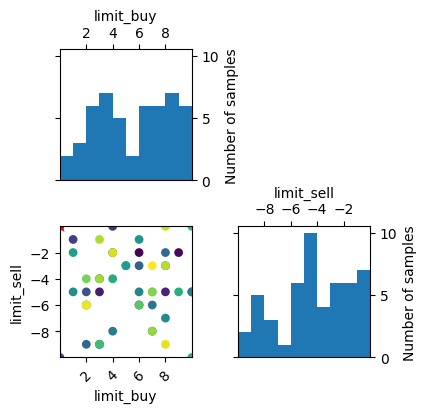

In [51]:
_ = plot_evaluations(optimize_result, bins=10)

Density.

In [52]:
from skopt.plots import plot_objective

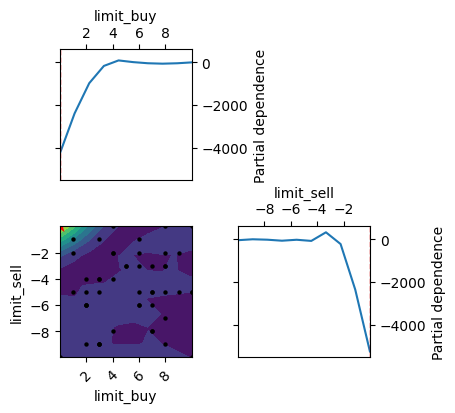

In [53]:
_ = plot_objective(optimize_result, n_points=10)